In [5]:
import sys
sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

ValueError: list.remove(x): x not in list

In [2]:
import tensorflow as tf
import numpy as np
import cv2
import os
from tqdm import tqdm
from random import shuffle
import matplotlib.pyplot as plt
import tflearn
from tflearn.layers.conv import conv_2d,max_pool_2d
from tflearn.layers.core import input_data,dropout,fully_connected
from tflearn.layers.estimator import regression

In [3]:
TRAIN_DIR='/home/rahulchakwate/My_tensorflow/DataSets/cats_and_dogs_2/train_mini'
IMG_SIZE=50
LR=1e-3
MODEL_NAME='cat-dog-convnet'

def create_label(image_name):
    word_label=image_name.split('.')[-3]
    if word_label=='cat':
        return np.array([1,0])
    elif word_label=='dog':
        return np.array([0,1])


In [4]:
def create_train_data():
    training_data=[]
    for img in tqdm(os.listdir(TRAIN_DIR)):
        path=os.path.join(TRAIN_DIR,img)
        img_data=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img_data=cv2.resize(img_data,(IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img_data),create_label(img)])
    shuffle(training_data)
    np.save('train_data.npy',training_data)
    return training_data



In [5]:
train_data=create_train_data()

100%|██████████| 1001/1001 [00:08<00:00, 121.03it/s]


In [7]:
train=train_data[:800]
test=train_data[800:]
X_train=np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
y_train=np.array([i[1] for i in train])
X_val=np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
y_val=np.array([i[1] for i in test])
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(800, 50, 50, 1)
(800, 2)
(201, 50, 50, 1)
(201, 2)


In [24]:
tf.reset_default_graph()
convnet=input_data(shape=[None,IMG_SIZE,IMG_SIZE,1],name='input')
convnet=conv_2d(convnet,32,5,activation='relu')
convnet=max_pool_2d(convnet,5)
convnet=conv_2d(convnet,64,5,activation='relu')
convnet=max_pool_2d(convnet,5)
convnet=conv_2d(convnet,128,5,activation='relu')
convnet=max_pool_2d(convnet,5)
convnet=conv_2d(convnet,64,5,activation='relu')
convnet=max_pool_2d(convnet,5)
convnet=conv_2d(convnet,32,5,activation='relu')
convnet=max_pool_2d(convnet,5)
convnet=fully_connected(convnet,1024,activation='relu')
convnet=dropout(convnet,0.8)
convnet=fully_connected(convnet,2,activation='softmax')
convnet=regression(convnet,optimizer='adam',learning_rate=LR,loss='categorical_crossentropy',name='targets')

model=tflearn.DNN(convnet,tensorboard_dir='/tmp/log',tensorboard_verbose=3)

model.fit({'input':X_train},{'targets':y_train},n_epoch=10,validation_set=({'input':X_val},{'targets':y_val}),snapshot_step=10, show_metric=True, run_id=MODEL_NAME)


Training Step: 25  | total loss: 0.70041 | time: 4.120s
| Adam | epoch: 002 | loss: 0.70041 - acc: 0.4917 -- iter: 768/800
Training Step: 26  | total loss: 0.69764 | time: 5.388s
| Adam | epoch: 002 | loss: 0.69764 - acc: 0.5063 | val_loss: 0.69784 - val_acc: 0.4279 -- iter: 800/800
--


In [22]:
!tensorboard --logdir='/tmp/log'

2018-09-26 23:49:16.385376: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
TensorBoard 1.8.0 at http://rahulchakwate-Inspiron-5559:6006 (Press CTRL+C to quit)
W0926 23:49:19.598454 Thread-1 application.py:274] path /[[_dataImageSrc]] not found, sending 404
W0926 23:49:19.606714 Thread-1 application.py:274] path /[[_imageURL]] not found, sending 404
^C


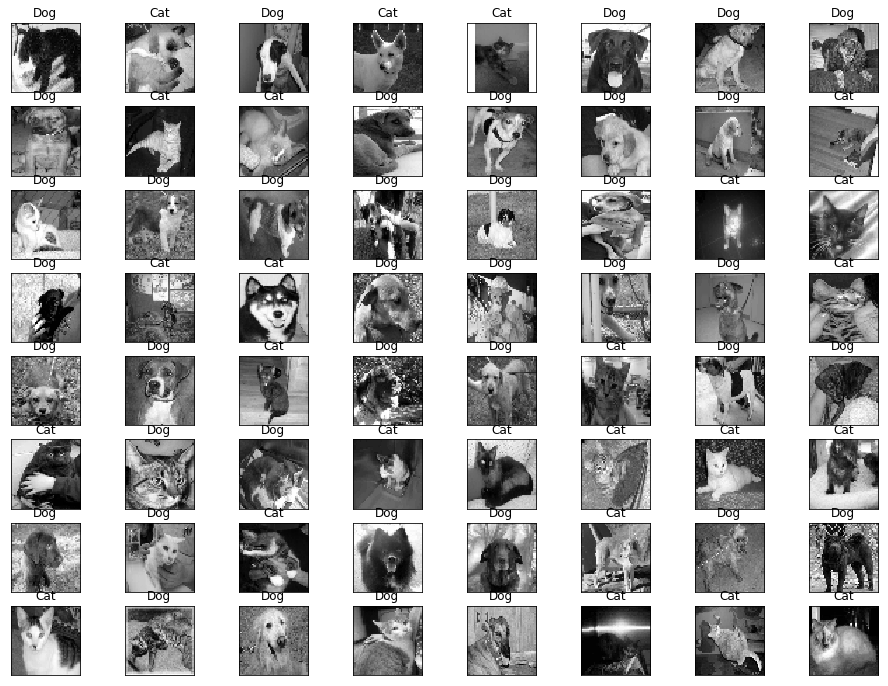

In [57]:
fig=plt.figure(figsize=(16,12))

for num,data in enumerate(train_data[800:864]):
    img_num=data[1]
    img_data=data[0]
    y=fig.add_subplot(8,8,num+1)
    orig=img_data
    data=img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    model_out=model.predict([data])[0]
    
    if np.argmax(model_out)==1:
        str_label='Dog'
    else:
        str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()